# Cross Sound ADCP Data Retrieval (a convenient tutorial)

**Purpose:** Show the *manual* way to retrieve a batch of data from the FOCI erddap and provide an automated pythonic example of the same.  The focus here will be on ADCP Velocity data from the Cross Sound Moorings.

FOCI Institutional Knowledge that may not be readily transparent:
- CS is the 2digit ID for Cross Sound.  CSP is the ID for Cross Sound Profiler which is the classification we give ADCP focused moorings.
- Additional FOCI nomenclature is used for unique identification of general position within a geographic region, thus site CSP-1 and CSP-2 are both in the Cross Sound region, but are not at the exact same location.  Final data product may need to ignore a subclass of data, but this can be done later.
- U,V data are a gridded dataset (as are subsequent products like Current Speed, and Current Direction).  ADCP's also record scalar values at the ADCP depth (so an ADCP creates two datastream, gridded and tabular - these are threads/erddap centric deliniations)
- Only final QC'd ADCP data has been archived historically.  Preliminary Data may exist but only for recent (2020+) deployments and a format change has been implemented ~2020 for variable naming which may be evident in the retrieved datasets.

**VPN Requirement** Rerendering or following along with the code / links in this tutorial requires VPN access to the FOCI erddap [http://ecofoci-field.pmel.noaa.gov:8080/erddap](http://ecofoci-field.pmel.noaa.gov:8080/erddap) and internal internet site : [http://ecofoci-field.pmel.noaa.gov](http://ecofoci-field.pmel.noaa.gov)

For the Python Examples:  
- Python Vesrion: Python 3.8
- Libraries: 
    - erddapy *used to interface with erddap*
    - pandas and/or xarray *used to manipulate data*
    - other dependencies the former ones may install automatically (like numpy)

## Manually Search and Retrieve Data

- Go to the erddap start page [http://ecofoci-field.pmel.noaa.gov:8080/erddap](http://ecofoci-field.pmel.noaa.gov:8080/erddap) , click on **Advance Search** on the right hand side, about midway down.
    - input "CSP ADCP" into the search field ***see comment above on institutional knowledge***
    - change "protocol" to just "griddap" - this is erddaps (threads) gridded format which we use for the ADCP data.  Results are shown at the bottom of the screen in this method.
    - click through on any "data" link to arrive at the Individual Dataset Interface.  Here you can select the parameters you want and the data output format.
**Great, you have retrieved the data for a single dataset, but no one wants to do this for more than a handful of datasets and its likely one already knows how to do this**
    
The results from the search above can be compared to the results available here [http://akutan.pmel.noaa.gov:8080/erddap/search/advanced.html?page=1&itemsPerPage=1000&searchFor=CSP+ADCP&protocol=griddap](http://akutan.pmel.noaa.gov:8080/erddap/search/advanced.html?page=1&itemsPerPage=1000&searchFor=CSP+ADCP&protocol=griddap).  Notice how the search parameters are embedded in the url and the results are shown as a table on a webpage (I remove a lot of unneeded ones to shorten the url, they are empty and therefor return to their default value if omitted).  ERDDAP can actually output many formats and every page can be retrieved as a csv or json or any other format that ERDDAP supports.  You just have to modify the filetype from `html` in the url **notice it is just after the word "advaced" in the above link**.  So the following one is the same as before but will cause a csv file to be downloaded with the same results [http://akutan.pmel.noaa.gov:8080/erddap/search/advanced.csv?page=1&itemsPerPage=1000&searchFor=CSP+ADCP&protocol=griddap](http://akutan.pmel.noaa.gov:8080/erddap/search/advanced.csv?page=1&itemsPerPage=1000&searchFor=CSP+ADCP&protocol=griddap)

Why is this useful? Because you now have a csv file where each entry/row reflects one of the resultant datasets.  You can read this file in via your favorite software and loop over the rows.  Specifically the first column is the url link to the dataset.  However, if you click on it it just takes you back to the final step above... manual downloading... but using the file-ending technique in the url again we can download the entire dataset (all variables, all times) by replacing the `html` with `nc` or your desired/supported format.  E.g. [http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_05csp1a_final.html](http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_05csp1a_final.html) is the dataset landing page but [http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_05csp1a_final.nc](http://akutan.pmel.noaa.gov:8080/erddap/griddap/ADCP_Mooring_05csp1a_final.nc) will dump the entire dataset as a netcdf file (the version can be specified to some extent by different file endings - see the link in the next paragraph).  

***User Note: Griddap data plays well with netcdf files, tabular data plays better as csv files.  For python this means use Xarray for gridded files and pandas for tabular data.  For other software, you may need to play around with available data formats to see what works for you***  A list of file types available can be found here - [http://akutan.pmel.noaa.gov:8080/erddap/griddap/documentation.html#fileType](http://akutan.pmel.noaa.gov:8080/erddap/griddap/documentation.html#fileType)

### Summary

Build your search via the web interface... explore the datasets and get familiar with whats available.  Then get a csv version of the results you want (or compile it yourself) and loop through the rows modifing the `html` of the dataset url with `nc` or `csv` or `json` or `mat` and it should automatically download the entire dataset with all variables and all times.  If you would like to see your results without downloading a file, choose the ending `htmlTable` to have a tabular set of results fed to your browser.  Modifying the url to select only certain times or certain variables is trivial.  Just build the datarequest you want on an erddap dataset webpage and then click the "just generate url" button and you will see the format that you can manually modify.

If you have software that will load dynamically from a url, you may be able to directly feed in the url generated above.  Otherwise, you are now saddled with a single file for each dataset that you need to do any subsequent post processing on. 

## Programatically Search and Retrieve Data

As exhibited above ERDDAP has the beauty of having a web interface and a RESTful programmatic interface.  The pythonic instructions provided below may be easily translated to other software like Matlab (or may already have some examples available).  They rely on a library called `erddapy` but really, you could build your url with any method you choose and send your web request via the `urllib` library or in some cases directly via the software (pandas lets you put a url in as the source for `from_csv()` methods.

The following example will lean on pandas/xarray utilites to thin the dataset down on the fly instead of working on local files.  This is not the only way to do things.  There are some serverside methods to filter data and also some idealized was to retrieve data that apply compression to files, etc.  If performance is a demanding portion of your workflow - you will want to explore more alternatives.

In [51]:
# Use Python 3.8 - if you don't have this installed, i recomend using conda to setup env's so you aren't messing with anything you may already have installed.  
# standard python imports.  if you dont have these packages, they are easily installed via conda or pip
import numpy as np
import xarray as xa
from erddapy import ERDDAP

In [52]:
server_url='http://ecofoci-field.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url) #initiate the erddap class
e.protocol = 'griddap' #specify the protocol like we did for the advanced search above
searchresults = pd.read_csv(e.get_search_url(response='csv', search_for='CSP ADCP')) #same as the text box search in the manual method

searchresults

,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 05CSP-1A,QC'd (final) Gridded ADCP Vel Data from 05CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_05csp1a_final
1,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 06CSP-1A,QC'd (final) Gridded ADCP Vel Data from 06CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_06csp1a_final
2,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 10CSP-1A,QC'd (final) Gridded ADCP Vel Data from 10CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_10csp1a_final
3,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 10CSP-3A,QC'd (final) Gridded ADCP Vel Data from 10CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_10csp3a_final
4,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 11CSP-11A,QC'd (final) Gridded ADCP Vel Data from 11CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_11csp11a_final
5,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 11CSP-1A,QC'd (final) Gridded ADCP Vel Data from 11CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel.noaa.gov/,http://akutan.pmel.noaa.gov:8080/erddap/rss/AD...,http://akutan.pmel.noaa.gov:8080/erddap/subscr...,NOAA/PMEL - EcoFOCI,ADCP_Mooring_11csp1a_final
6,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,NaN,http://akutan.pmel.noaa.gov:8080/erddap/gridda...,NaN,http://akutan.pmel.noaa.gov:8080/erddap/files/...,QC'd (final) ADCP Vel Data from 11CSP-2A,QC'd (final) Gridded ADCP Vel Data from 11CSP-...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/metada...,http://akutan.pmel.noaa.gov:8080/erddap/info/A...,https://pmel

So this is the results we got from the manual search.  Your first column is exactly the link resource I discussed then. We can save this and loop over it simply with python/pandas/erddapy

In [53]:
#loop over the results, download each into a dictionary of results for now.  We will work on each deployment individually.

In [54]:
data = {} #empty dictionary
for dataset_id in sorted(searchresults['Dataset ID'].values):

        e.dataset_id=dataset_id
        e.response = 'ncCF' #important for using netcdf and xarray together, but nc exists too
        ds = e.to_xarray(decode_times=True)
        data.update({dataset_id:ds}) #saves each dataset into a dictionary where the key is the dataset id

In [55]:
data.keys()

dict_keys(['ADCP_Mooring_05csp1a_final', 'ADCP_Mooring_06csp1a_final', 'ADCP_Mooring_10csp1a_final', 'ADCP_Mooring_10csp3a_final', 'ADCP_Mooring_11csp11a_final', 'ADCP_Mooring_11csp1a_final', 'ADCP_Mooring_11csp2a_final', 'ADCP_Mooring_11csp3a_final', 'ADCP_Mooring_13csp11a_final', 'ADCP_Mooring_13csp1a_final', 'ADCP_Mooring_13csp2a_final', 'ADCP_Mooring_13csp3a_final'])

In [56]:
data['ADCP_Mooring_05csp1a_final'] #this will just show a summary in jupyternotebooks of the chosen dataset in an xarray container

<xarray.Dataset>
Dimensions:        (time: 2652, depth: 32, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2005-08-11T05:00:00 ... 2005-11-29T1...
  * depth          (depth) float64 32.0 40.0 48.0 56.0 ... 264.0 272.0 280.0
  * latitude       (latitude) float32 58.16
  * longitude      (longitude) float64 223.4
Data variables:
    vcomp_current  (time, depth, latitude, longitude) float32 ...
    ucomp_current  (time, depth, latitude, longitude) float32 ...
    w_1204         (time, depth, latitude, longitude) float32 ...
    Werr_1201      (time, depth, latitude, longitude) float32 ...
Attributes: (12/39)
    cdm_data_type:                 Grid
    COMPOSITE:                     1
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    CREATION_DATE:                 July 29, 2020 22:42 UTC
    creation_date:                 April 16, 2020 21:06 UTC
    DATA_CMNT:                     adcp data:vel:pg 4-beam cuttoff<25.0%:decl...
    ...                            ...
    time_coverage_end:             2005-11-29T16:00:00Z
    time_coverage_start:           2005-08-11T05:00:00Z
    title:                         QC'd (final) ADCP Vel Data from 05CSP-1A
    WATER_DEPTH:                   304
    WATER_MASS:                    BS
    Westernmost_Easting:           223.43060302734375

## At this point, its all python/xarray

Whatever features you want to do, QC you want to check, products you want to create, you can loop over the data dictionary keys.

Examples for an individual dataset:

In [57]:
#calculate the mean along one dimension
value.mean(dim='depth') 

<xarray.Dataset>
Dimensions:        (time: 6516, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2013-02-01T05:00:00 ... 2013-10-30T1...
  * latitude       (latitude) float32 58.12
  * longitude      (longitude) float64 223.4
Data variables:
    vcomp_current  (time, latitude, longitude) float32 -13.9 0.8435 ... 25.19
    ucomp_current  (time, latitude, longitude) float32 2.754 7.669 ... 12.97
    w_1204         (time, latitude, longitude) float32 nan nan nan ... nan nan
    Werr_1201      (time, latitude, longitude) float32 nan nan nan ... nan nan
    CS             (time, latitude, longitude) float32 24.18 14.62 ... 31.63

In [58]:
#calculate the mean along one dimension for all files

for key,value in data.items():
    print(f'{key} - erddap dataset')
    print(f'{value.mean(dim="depth")}')

ADCP_Mooring_05csp1a_final - erddap dataset
<xarray.Dataset>
Dimensions:        (time: 2652, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2005-08-11T05:00:00 ... 2005-11-29T1...
  * latitude       (latitude) float32 58.16
  * longitude      (longitude) float64 223.4
Data variables:
    vcomp_current  (time, latitude, longitude) float32 -32.85 -6.752 ... 44.02
    ucomp_current  (time, latitude, longitude) float32 -23.4 -5.615 ... 11.43
    w_1204         (time, latitude, longitude) float32 nan nan nan ... nan nan
    Werr_1201      (time, latitude, longitude) float32 nan nan nan ... nan nan
ADCP_Mooring_06csp1a_final - erddap dataset
<xarray.Dataset>
Dimensions:        (time: 4944, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2006-08-28T23:00:00 ... 2007-03-22T2...
  * latitude       (latitude) float32 58.17
  * longitude      (longitude) float64 223.4
Data variables:
    vcomp_current  (time, latitude, longitude) 

## Using the data in the last file looped through - show some plots, a calculation and save the file to a netcdf

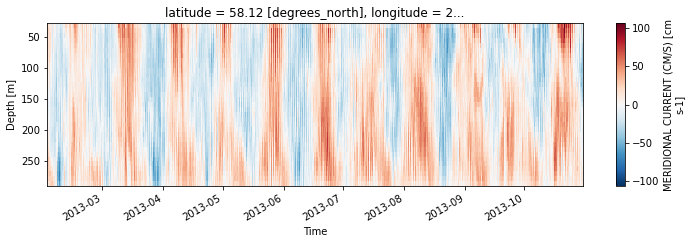

In [59]:
#plot the v component
value.vcomp_current.T.plot(figsize=(12,3),yincrease=False)

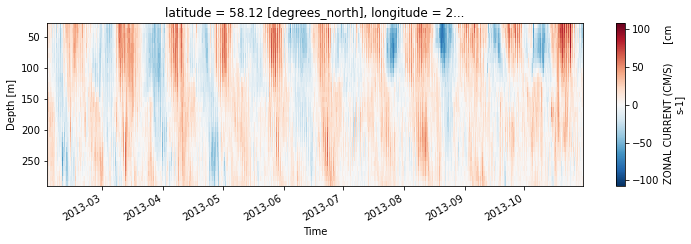

In [60]:
#plot the u component
value.ucomp_current.T.plot(figsize=(12,3),yincrease=False)

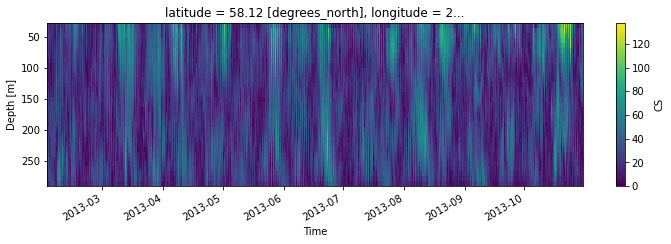

In [61]:
#calculate speed, add to dataset and plot
value['CS'] = np.sqrt(value.ucomp_current**2 + value.vcomp_current**2)

value.CS.T.plot(figsize=(12,3),yincrease=False)

In [62]:
#save file to netcdf with calculated Speed, force time units to be useful and consistent across files
value.to_netcdf(key+'.nc',encoding={'time':{'units':'days since 1900-01-01'}})

In [64]:
#calculate the speed for all files and save
for key,value in data.items():
    print(f'{key} - erddap dataset to netcdf')
    value['CS'] = np.sqrt(value.ucomp_current**2 + value.vcomp_current**2)
    # value.CS.T.plot(figsize=(12,3),yincrease=False)
    value.to_netcdf(key+'.nc',encoding={'time':{'units':'days since 1900-01-01'}})

ADCP_Mooring_05csp1a_final - erddap dataset to netcdf
ADCP_Mooring_06csp1a_final - erddap dataset to netcdf
ADCP_Mooring_10csp1a_final - erddap dataset to netcdf
ADCP_Mooring_10csp3a_final - erddap dataset to netcdf
ADCP_Mooring_11csp11a_final - erddap dataset to netcdf
ADCP_Mooring_11csp1a_final - erddap dataset to netcdf
ADCP_Mooring_11csp2a_final - erddap dataset to netcdf
ADCP_Mooring_11csp3a_final - erddap dataset to netcdf
ADCP_Mooring_13csp11a_final - erddap dataset to netcdf
ADCP_Mooring_13csp1a_final - erddap dataset to netcdf
ADCP_Mooring_13csp2a_final - erddap dataset to netcdf
ADCP_Mooring_13csp3a_final - erddap dataset to netcdf
